In [1]:
#@title Installation. { vertical-output: true }
#@markdown Run this notebook in Google Colab by following [this link](https://colab.research.google.com/github/google-research/perch/blob/main/embed_audio.ipynb).
#@markdown
#@markdown Run this cell to install the project dependencies.
%pip install git+https://github.com/google-research/perch.git

  Cloning https://github.com/google-research/perch.git to /tmp/pip-req-build-7zn8ih6c
  Running command git clone --filter=blob:none --quiet https://github.com/google-research/perch.git /tmp/pip-req-build-7zn8ih6c
  Resolved https://github.com/google-research/perch.git to commit 5701b76a80b9e37975dc42c90cd97d8138d906e6
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/google-research/perch-hoplite.git to /tmp/pip-install-m0gmazhw/perch-hoplite_f5df5a3e7d364ab4881613d9f5e536db
  Running command git clone --filter=blob:none --quiet https://github.com/google-research/perch-hoplite.git /tmp/pip-install-m0gmazhw/perch-hoplite_f5df5a3e7d364ab4881613d9f5e536db
  Resolved https://github.com/google-research/perch-hoplite.git to commit 89510073db5052959ffd3589d2e773d9e7c3e5c8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata 

In [1]:
#@title Imports. { vertical-output: true }

from etils import epath
from ml_collections import config_dict
import numpy as np
import tensorflow as tf
import tqdm
from chirp.inference import colab_utils
colab_utils.initialize(use_tf_gpu=True, disable_warnings=True)

from chirp import audio_utils
from chirp.inference import embed_lib
from chirp.inference import tf_examples
from perch_hoplite.zoo import model_configs

/usr/local/lib/python3.11/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.5.3 is installed, but it is not compatible with the installed jaxlib version 0.6.2, so it will not be used.
  warnings.warn(


In [2]:
#@title Basic Configuration. { vertical-output: true }

#@markdown Define the model: perch or birdnet are most common for birds.
model_choice = 'humpback'  #@param['perch_8', 'humpback', 'multispecies_whale', 'surfperch', 'birdnet_V2.3']
#@markdown Set the base directory for the project.
working_dir = '/tmp/agile'  #@param

# Set the embedding and labeled data directories.
embeddings_path = epath.Path(working_dir) / 'embeddings'
labeled_data_path = epath.Path(working_dir) / 'labeled'
embeddings_glob = embeddings_path / 'embeddings-*'

# OPTIONAL: Set up separation model.
separation_model_key = 'separator_model_tf'  #@param
separation_model_path = ''  #@param

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
#@title Create a new folder in Drive (if it doesn't already exist) within your Google drive.
base_dir = '/content/drive/MyDrive/'
#@ markdown Name of your new folder in Drive
new_folder_name = 'whale_denoising' #@param

drive_output_directory = base_dir + new_folder_name

try:
  if not os.path.exists(drive_output_directory):
    os.makedirs(drive_output_directory, exist_ok=True)
    print(f'Directory {drive_output_directory} created successfully.')
  else:
    print(f'Directory {drive_output_directory} already exists.')
except OSError as e:
    print("Error:", e)

Directory /content/drive/MyDrive/whale_denoising already exists.


In [5]:
#@title Embedding Configuration. { vertical-output: true }

config = config_dict.ConfigDict()
config.embed_fn_config = config_dict.ConfigDict()
config.embed_fn_config.model_config = config_dict.ConfigDict()

#@markdown IMPORTANT: Select the target audio files.
#@markdown source_file_patterns should contain a list of globs of audio files, like:
#@markdown ['/home/me/*.wav', '/home/me/other/*.flac']
#config.source_file_patterns = ['gs://chirp-public-bucket/soundscapes/powdermill/Recording*/*.wav']  #@param
config.source_file_patterns = ['/content/drive/MyDrive/whale_denoising/noisy/*.wav', '/content/drive/MyDrive/whale_denoising/clean/*.wav']  #@param
config.output_dir = embeddings_path.as_posix()

preset_info = model_configs.get_preset_model_config(model_choice)
config.embed_fn_config.model_key = preset_info.model_key
config.embed_fn_config.model_config = preset_info.model_config

# Only write embeddings to reduce size.
config.embed_fn_config.write_embeddings = True
config.embed_fn_config.write_logits = False
config.embed_fn_config.write_separated_audio = False
config.embed_fn_config.write_raw_audio = False

#@markdown File sharding automatically splits audio files into one-minute chunks
#@markdown for embedding. This limits both system and GPU memory usage,
#@markdown especially useful when working with long files (>1 hour).
use_file_sharding = False  #@param {type:'boolean'}
if use_file_sharding:
  config.shard_len_s = 60.0

# Number of parent directories to include in the filename.
config.embed_fn_config.file_id_depth = 1

In [6]:
#@title Set up. { vertical-output: true }

# Set up the embedding function, including loading models.
embed_fn = embed_lib.EmbedFn(**config.embed_fn_config)
print('\n\nLoading model(s)...')
embed_fn.setup()

# Create output directory and write the configuration.
output_dir = epath.Path(config.output_dir)
output_dir.mkdir(exist_ok=True, parents=True)
embed_lib.maybe_write_config(config, output_dir)

# Create SourceInfos.
source_infos = embed_lib.create_source_infos(
    config.source_file_patterns,
    num_shards_per_file=config.get('num_shards_per_file', -1),
    shard_len_s=config.get('shard_len_s', -1))
print(f'Found {len(source_infos)} source infos.')

print('\n\nTest-run of model...')
window_size_s = config.embed_fn_config.model_config.window_size_s
sr = config.embed_fn_config.model_config.sample_rate
z = np.zeros([int(sr * window_size_s)], dtype=np.float32)
embed_fn.embedding_model.embed(z)
print('Setup complete!')



Loading model(s)...
Found 1473 source infos.


Test-run of model...
Setup complete!


# Extract the model

In [7]:
embedding_model = embed_fn.embedding_model

In [ ]:
#@title Run embedding. { vertical-output: true }

# Uses multiple threads to load audio before embedding.
# This tends to be faster, but can fail if any audio files are corrupt.

embed_fn.min_audio_s = 1.0
record_file = (output_dir / 'embeddings.tfrecord').as_posix()
succ, fail = 0, 0

existing_embedding_ids = embed_lib.get_existing_source_ids(
    output_dir, 'embeddings-*')

new_source_infos = embed_lib.get_new_source_infos(
    source_infos, existing_embedding_ids, config.embed_fn_config.file_id_depth)

print(f'Found {len(existing_embedding_ids)} existing embedding ids. \n'
      f'Processing {len(new_source_infos)} new source infos. ')

try:
  audio_loader = lambda fp, offset: audio_utils.load_audio_window(
      fp, offset, sample_rate=config.embed_fn_config.model_config.sample_rate,
      window_size_s=config.get('shard_len_s', -1.0))
  audio_iterator = audio_utils.multi_load_audio_window(
      filepaths=[s.filepath for s in new_source_infos],
      offsets=[s.shard_num * s.shard_len_s for s in new_source_infos],
      audio_loader=audio_loader,
  )
  with tf_examples.EmbeddingsTFRecordMultiWriter(
      output_dir=output_dir, num_files=config.get('tf_record_shards', 1)) as file_writer:
    for source_info, audio in tqdm.tqdm(
        zip(new_source_infos, audio_iterator), total=len(new_source_infos)):
      if not embed_fn.validate_audio(source_info, audio):
        continue
      file_id = source_info.file_id(config.embed_fn_config.file_id_depth)
      offset_s = source_info.shard_num * source_info.shard_len_s
      example = embed_fn.audio_to_example(file_id, offset_s, audio)
      if example is None:
        fail += 1
        continue
      file_writer.write(example.SerializeToString())
      succ += 1
    file_writer.flush()
finally:
  del(audio_iterator)
print(f'\n\nSuccessfully processed {succ} source_infos, failed {fail} times.')

fns = [fn for fn in output_dir.glob('embeddings-*')]
ds = tf.data.TFRecordDataset(fns)
parser = tf_examples.get_example_parser()
ds = ds.map(parser)
for ex in ds.as_numpy_iterator():
  print(ex['filename'])
  print(ex['embedding'].shape, flush=True)
  break

Found 0 existing embedding ids. 
Processing 1473 new source infos. 


100%|██████████| 1473/1473 [07:24<00:00,  3.32it/s]



Successfully processed 1473 source_infos, failed 0 times.
b'noisy/whale_1_10k.wav'
(1, 1, 2048)


# This is wrong

In [16]:
import json
import torch
from chirp.models import build_model
from chirp.inference import embed_lib

# Load config from JSON
with open("/tmp/agile/embeddings/config.json", "r") as f:
    full_config = json.load(f)

model_config_dict = full_config["embed_fn_config"]["model_config"]

# Build model
embedding_model = build_model.build_model(model_config_dict)

# Load weights from TensorFlow Hub
model_url = model_config_dict["model_url"]
embedding_model = embed_lib.load_tfhub_model(model_url, embedding_model)
embedding_model.eval()

# Wrap in embed_fn
embed_fn = embed_lib.EmbedFn(embedding_model, frontend=True)

ImportError: cannot import name 'build_model' from 'chirp.models' (unknown location)

In [27]:
print(type(embedding_model))
print(dir(embedding_model))


<class 'perch_hoplite.zoo.models_tf.GoogleWhaleModel'>
['__annotations__', '__class__', '__dataclass_fields__', '__dataclass_params__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__match_args__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'batch_embed', 'class_list', 'embed', 'frame_audio', 'from_config', 'hop_size_s', 'load_humpback_model', 'model', 'model_url', 'normalize_audio', 'peak_norm', 'sample_rate', 'window_size_s']


# Train Denoiser

In [11]:
import torch
import torch.nn as nn
from tqdm import tqdm
import numpy as np

# Simple 1D convolutional denoiser
class Denoiser1D(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=15, padding=7),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=15, padding=7),
            nn.ReLU(),
            nn.Conv1d(64, 32, kernel_size=15, padding=7),
            nn.ReLU(),
            nn.Conv1d(32, 1, kernel_size=15, padding=7)
        )

    def forward(self, x):
        return self.net(x)

denoiser = Denoiser1D().cuda()
optimizer = torch.optim.Adam(denoiser.parameters(), lr=1e-3)
mse_loss = nn.MSELoss()



Define data loader

In [9]:
from torch.utils.data import Dataset, DataLoader
import torchaudio
import glob

class NoisyWhaleDataset(Dataset):
    def __init__(self, paths):
        self.paths = paths

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        x, _ = torchaudio.load(self.paths[idx])
        return x.squeeze(0)

noisy_paths = sorted(glob.glob('/content/drive/MyDrive/whale_denoising/noisy/*.wav'))
noisy_dataset = NoisyWhaleDataset(noisy_paths)
train_loader = DataLoader(noisy_dataset, batch_size=16, shuffle=True)



In [29]:
clean_paths = sorted(glob.glob('/content/drive/MyDrive/whale_denoising/clean/*.wav'))

In [14]:
print(dir(embed_fn))

['BundleContextParam', 'BundleFinalizerParam', 'DoFnProcessParams', 'DynamicTimerTagParam', 'ElementParam', 'KeyParam', 'PaneInfoParam', 'RestrictionParam', 'SetupContextParam', 'SideInputParam', 'StateParam', 'TimerParam', 'TimestampParam', 'WatermarkEstimatorParam', 'WindowParam', 'WindowedValueParam', '__annotations__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_can_yield_batches', '_get_display_data_namespace', '_get_element_type_from_return_annotation', '_get_input_batch_type_normalized', '_get_or_create_type_hints', '_get_output_batch_type_normalized', '_known_urns', '_log_exception', '_process_argspec_fn', '_process_batch_defined', '_process_batch_yields_elements', 

# Training Loop

In [44]:
for epoch in range(50):  # You can adjust the number of epochs
    denoiser.train()
    total_loss = 0
    total_score = 0
    total_batches = 0

    for noisy in tqdm(train_loader):
        noisy = noisy.unsqueeze(1).cuda()  # shape: (B, 1, T)
        denoised = denoiser(noisy)

        # === 1. Reconstruction Loss (what we train with) ===
        loss = mse_loss(denoised, noisy)

        # === 2. Convert to numpy for frozen TF model (whale score logging) ===
        def to_numpy_for_tf(x):
            x = x.detach().squeeze(1).cpu().numpy()
            x = x[..., np.newaxis].astype(np.float32)
            target_len = 39124
            return x[:, :target_len, :] if x.shape[1] > target_len else np.pad(
                x, ((0, 0), (0, target_len - x.shape[1]), (0, 0))
            )

        denoised_np = to_numpy_for_tf(denoised)

        # === 3. Whale score (frozen TF model) ===
        whale_scores = embedding_model.model(denoised_np, False, None).numpy()
        mean_score = whale_scores.mean()

        # === 4. Train step ===
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # === 5. Logging ===
        total_loss += loss.item()
        total_score += mean_score
        total_batches += 1

    avg_loss = total_loss / total_batches
    avg_score = total_score / total_batches
    print(f"Epoch {epoch + 1} | Recon Loss: {avg_loss:.4f} | Whale Score (mean): {avg_score:.4f}")


100%|██████████| 58/58 [00:19<00:00,  3.00it/s]


Epoch 1 | Recon Loss: 0.0000 | Whale Score (mean): -0.8555


100%|██████████| 58/58 [00:19<00:00,  3.03it/s]


Epoch 2 | Recon Loss: 0.0000 | Whale Score (mean): -0.8619


100%|██████████| 58/58 [00:18<00:00,  3.14it/s]


Epoch 3 | Recon Loss: 0.0000 | Whale Score (mean): -0.8630


100%|██████████| 58/58 [00:18<00:00,  3.07it/s]


Epoch 4 | Recon Loss: 0.0000 | Whale Score (mean): -0.8616


100%|██████████| 58/58 [00:18<00:00,  3.14it/s]


Epoch 5 | Recon Loss: 0.0000 | Whale Score (mean): -0.8616


100%|██████████| 58/58 [00:18<00:00,  3.15it/s]


Epoch 6 | Recon Loss: 0.0000 | Whale Score (mean): -0.8575


100%|██████████| 58/58 [00:19<00:00,  3.04it/s]


Epoch 7 | Recon Loss: 0.0000 | Whale Score (mean): -0.8687


100%|██████████| 58/58 [00:18<00:00,  3.17it/s]


Epoch 8 | Recon Loss: 0.0000 | Whale Score (mean): -0.8619


100%|██████████| 58/58 [00:18<00:00,  3.07it/s]


Epoch 9 | Recon Loss: 0.0000 | Whale Score (mean): -0.8727


100%|██████████| 58/58 [00:18<00:00,  3.19it/s]


Epoch 10 | Recon Loss: 0.0000 | Whale Score (mean): -0.8616


100%|██████████| 58/58 [00:18<00:00,  3.16it/s]


Epoch 11 | Recon Loss: 0.0000 | Whale Score (mean): -0.8597


100%|██████████| 58/58 [00:18<00:00,  3.09it/s]


Epoch 12 | Recon Loss: 0.0000 | Whale Score (mean): -0.8644


100%|██████████| 58/58 [00:19<00:00,  3.04it/s]


Epoch 13 | Recon Loss: 0.0000 | Whale Score (mean): -0.8619


100%|██████████| 58/58 [00:19<00:00,  3.04it/s]


Epoch 14 | Recon Loss: 0.0000 | Whale Score (mean): -0.8532


100%|██████████| 58/58 [00:18<00:00,  3.11it/s]


Epoch 15 | Recon Loss: 0.0000 | Whale Score (mean): -0.8661


100%|██████████| 58/58 [00:19<00:00,  3.05it/s]


Epoch 16 | Recon Loss: 0.0000 | Whale Score (mean): -0.8692


100%|██████████| 58/58 [00:18<00:00,  3.13it/s]


Epoch 17 | Recon Loss: 0.0000 | Whale Score (mean): -0.8567


100%|██████████| 58/58 [00:18<00:00,  3.17it/s]


Epoch 18 | Recon Loss: 0.0000 | Whale Score (mean): -0.8595


100%|██████████| 58/58 [00:18<00:00,  3.06it/s]


Epoch 19 | Recon Loss: 0.0000 | Whale Score (mean): -0.8644


100%|██████████| 58/58 [00:18<00:00,  3.19it/s]


Epoch 20 | Recon Loss: 0.0000 | Whale Score (mean): -0.8740


100%|██████████| 58/58 [00:18<00:00,  3.07it/s]


Epoch 21 | Recon Loss: 0.0000 | Whale Score (mean): -0.8830


100%|██████████| 58/58 [00:18<00:00,  3.17it/s]


Epoch 22 | Recon Loss: 0.0000 | Whale Score (mean): -0.8809


100%|██████████| 58/58 [00:18<00:00,  3.11it/s]


Epoch 23 | Recon Loss: 0.0000 | Whale Score (mean): -0.8787


100%|██████████| 58/58 [00:18<00:00,  3.07it/s]


Epoch 24 | Recon Loss: 0.0000 | Whale Score (mean): -0.8754


100%|██████████| 58/58 [00:18<00:00,  3.09it/s]


Epoch 25 | Recon Loss: 0.0000 | Whale Score (mean): -0.8684


100%|██████████| 58/58 [00:19<00:00,  2.99it/s]


Epoch 26 | Recon Loss: 0.0000 | Whale Score (mean): -0.8690


100%|██████████| 58/58 [00:18<00:00,  3.17it/s]


Epoch 27 | Recon Loss: 0.0000 | Whale Score (mean): -0.8679


100%|██████████| 58/58 [00:18<00:00,  3.07it/s]


Epoch 28 | Recon Loss: 0.0000 | Whale Score (mean): -0.8613


100%|██████████| 58/58 [00:18<00:00,  3.15it/s]


Epoch 29 | Recon Loss: 0.0000 | Whale Score (mean): -0.8676


100%|██████████| 58/58 [00:18<00:00,  3.15it/s]


Epoch 30 | Recon Loss: 0.0000 | Whale Score (mean): -0.8689


100%|██████████| 58/58 [00:19<00:00,  3.03it/s]


Epoch 31 | Recon Loss: 0.0000 | Whale Score (mean): -0.8725


100%|██████████| 58/58 [00:18<00:00,  3.15it/s]


Epoch 32 | Recon Loss: 0.0000 | Whale Score (mean): -0.8570


100%|██████████| 58/58 [00:19<00:00,  3.05it/s]


Epoch 33 | Recon Loss: 0.0000 | Whale Score (mean): -0.8654


100%|██████████| 58/58 [00:18<00:00,  3.18it/s]


Epoch 34 | Recon Loss: 0.0000 | Whale Score (mean): -0.8675


100%|██████████| 58/58 [00:18<00:00,  3.11it/s]


Epoch 35 | Recon Loss: 0.0000 | Whale Score (mean): -0.8648


100%|██████████| 58/58 [00:18<00:00,  3.12it/s]


Epoch 36 | Recon Loss: 0.0000 | Whale Score (mean): -0.8650


100%|██████████| 58/58 [00:18<00:00,  3.17it/s]


Epoch 37 | Recon Loss: 0.0000 | Whale Score (mean): -0.8978


100%|██████████| 58/58 [00:19<00:00,  2.92it/s]


Epoch 38 | Recon Loss: 0.0000 | Whale Score (mean): -1.0395


100%|██████████| 58/58 [00:18<00:00,  3.16it/s]


Epoch 39 | Recon Loss: 0.0000 | Whale Score (mean): -0.8398


100%|██████████| 58/58 [00:18<00:00,  3.10it/s]


Epoch 40 | Recon Loss: 0.0000 | Whale Score (mean): -0.8645


100%|██████████| 58/58 [00:18<00:00,  3.14it/s]


Epoch 41 | Recon Loss: 0.0000 | Whale Score (mean): -0.8722


100%|██████████| 58/58 [00:18<00:00,  3.18it/s]


Epoch 42 | Recon Loss: 0.0000 | Whale Score (mean): -0.8569


100%|██████████| 58/58 [00:18<00:00,  3.08it/s]


Epoch 43 | Recon Loss: 0.0000 | Whale Score (mean): -0.8680


100%|██████████| 58/58 [00:18<00:00,  3.20it/s]


Epoch 44 | Recon Loss: 0.0000 | Whale Score (mean): -0.8659


100%|██████████| 58/58 [00:18<00:00,  3.10it/s]


Epoch 45 | Recon Loss: 0.0000 | Whale Score (mean): -0.8752


100%|██████████| 58/58 [00:18<00:00,  3.15it/s]


Epoch 46 | Recon Loss: 0.0000 | Whale Score (mean): -0.8597


100%|██████████| 58/58 [00:18<00:00,  3.18it/s]


Epoch 47 | Recon Loss: 0.0000 | Whale Score (mean): -0.8559


100%|██████████| 58/58 [00:19<00:00,  3.03it/s]


Epoch 48 | Recon Loss: 0.0000 | Whale Score (mean): -0.8597


100%|██████████| 58/58 [00:18<00:00,  3.17it/s]


Epoch 49 | Recon Loss: 0.0000 | Whale Score (mean): -0.8577


100%|██████████| 58/58 [00:19<00:00,  2.96it/s]

Epoch 50 | Recon Loss: 0.0000 | Whale Score (mean): -0.8594


# Save trained model to disk

In [47]:
torch.save(denoiser.state_dict(), "/content/drive/MyDrive/whale_denoising/whale_denoiser.pt")


# Listen to denoised output

In [45]:
denoiser.eval()
with torch.no_grad():
    test_waveform, _ = torchaudio.load(noisy_paths[0])
    test_tensor = test_waveform.unsqueeze(0).cuda()  # shape: (1, 1, T)
    denoised_tensor = denoiser(test_tensor).squeeze().cpu()

import IPython.display as ipd
print("🔊 Noisy input:")
ipd.display(ipd.Audio(test_waveform.numpy(), rate=10000))

print("🔊 Denoised output:")
ipd.display(ipd.Audio(denoised_tensor.numpy(), rate=10000))

🔊 Noisy input:


🔊 Denoised output:


In [46]:
print(torch.max(torch.abs(denoised - noisy)))


tensor(0.0367, device='cuda:0', grad_fn=<MaxBackward1>)


# Check that model output is a good measure of whaliness

Processing clean files...


100%|██████████| 550/550 [00:30<00:00, 18.08it/s]


Processing noisy files...


100%|██████████| 923/923 [08:18<00:00,  1.85it/s]



✅ Clean mean score: 4.1279
✅ Noisy mean score: -0.8687


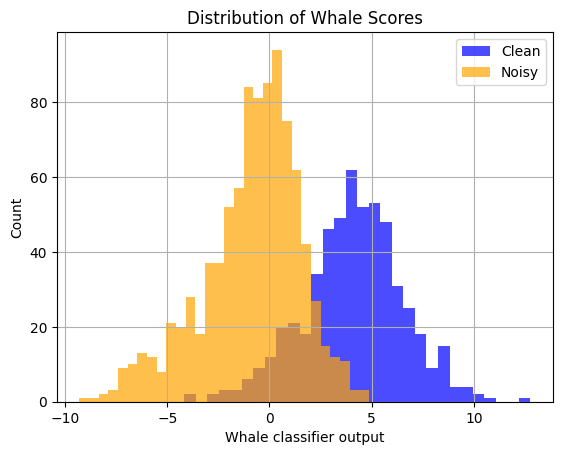

In [30]:
import numpy as np
import torchaudio
from tqdm import tqdm
import matplotlib.pyplot as plt

def load_and_prepare(path, target_len=39124):
    waveform, sr = torchaudio.load(path)
    waveform = waveform.squeeze(0).numpy()
    waveform = waveform[:target_len] if len(waveform) > target_len else np.pad(waveform, (0, target_len - len(waveform)))
    waveform = waveform.astype(np.float32)[np.newaxis, :, np.newaxis]  # shape (1, T, 1)
    return waveform

# Run model on clean and noisy sets
clean_scores = []
print("Processing clean files...")
for path in tqdm(clean_paths):
    audio = load_and_prepare(path)
    score = embedding_model.model(audio, False, None).numpy().item()
    clean_scores.append(score)

noisy_scores = []
print("Processing noisy files...")
for path in tqdm(noisy_paths):
    audio = load_and_prepare(path)
    score = embedding_model.model(audio, False, None).numpy().item()
    noisy_scores.append(score)

# Print means
print(f"\n✅ Clean mean score: {np.mean(clean_scores):.4f}")
print(f"✅ Noisy mean score: {np.mean(noisy_scores):.4f}")

# Optional: histogram plot
plt.hist(clean_scores, bins=30, alpha=0.7, label='Clean', color='blue')
plt.hist(noisy_scores, bins=30, alpha=0.7, label='Noisy', color='orange')
plt.xlabel("Whale classifier output")
plt.ylabel("Count")
plt.title("Distribution of Whale Scores")
plt.legend()
plt.grid(True)
plt.show()
